In [1]:
############## create sql table ################
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'stack_exchange_rnn_db'
q_tbname = 'question_table'
a_tbname = 'answer_table'
username = 'dan-laptop'
import os
password = os.environ['PGRES_PASSWORD']

engine = create_engine('postgresql://%s:%s@localhost:5432/%s'%(username,password,dbname))

## Now access sql db from python
con = None
connect_str = "dbname='%s' user='%s' host='localhost' password='%s'"%(dbname,username,password)
con = psycopg2.connect(connect_str)
cur = con.cursor() #create cursor for communicating with sql

In [3]:
import pandas as pd
################# make query ########################
sql_query = """
    SELECT answer_table.word_vec, answer_table.score 
    FROM answer_table
    INNER JOIN question_table
        on answer_table.q_id = question_table.q_id
        and question_table.view_count > 50
    LIMIT 10000;
"""
question_df = pd.read_sql_query(sql_query,con)
question_df.head()

,word_vec,score
0,"the,error,object,may,read,from,the,network,net...",0
1,"this,is,what,i,did,worked,for,me,when,reading,...",0
2,"possible,duplicate,stackoverflow,com,questions...",0
3,"you,are,looking,for,idxmax,in,1332,x,out,1332,...",2
4,"x,max,x,max,x,max,axis,1,max,index,this,works,...",0


In [4]:
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize

p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer('\w+')

In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.layers import Dense, Input, GRU, Embedding
from keras.models import Model
import six.moves.cPickle as cPickle

MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 300
word_index_length = 374000

embedding_layer = Embedding(word_index_length + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(128, dropout_W=0.2, dropout_U=0.2)(embedded_sequences)
preds = Dense(2, activation='softmax')(x)

mymodel = Model(sequence_input, preds)
mymodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
mymodel.load_weights('../Data_and_Models/stackex_gru.h5')
print('Gimme that overflow!')
vectorizer = cPickle.load(open('../Data_and_Models/rnn_tokenizer.pkl', 'rb'), encoding='latin1')
lg = mymodel

Using TensorFlow backend.


Gimme that overflow!


In [16]:
import numpy as np

def fetch_and_clean(text,model_prep=False):
    raw = BeautifulSoup(text, "lxml").get_text()
    raw = raw.lower()

    if model_prep == False:
        tokens = text_to_word_sequence(raw)
    elif model_prep == True:
        tokens = tokenizer.tokenize(raw)
        tokens = [word for word in tokens if not word.isdigit()]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = [p_stemmer.stem(i) for i in tokens]
    return tokens

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class MyRNN(BaseEstimator, TransformerMixin):
    def __init__(self, lg):
        self.lg = lg

    def predict(self, a_vect):
        just_tok = [fetch_and_clean(x,model_prep=False) for x in a_vect]
        just_tok = [vectorizer.texts_to_sequences(x) for x in just_tok]
        temp = []
        for items in just_tok: temp.append([x[0] for x in items if len(x)>0])
        just_tok = temp

        padded_seq = pad_sequences(just_tok,maxlen=MAX_SEQUENCE_LENGTH)
        seq = np.array(padded_seq)
        
        return self.lg.predict(seq)

In [18]:
RNN = MyRNN(lg)

In [19]:
question_df.ix[0]['word_vec']

"the,error,object,may,read,from,the,network,network,is,not,seekable,you,can't,go,back,in,the,general,case,you,could,replace,err,with,a,new,httperror,instance,that,reads,from,a,buffer,like,io,bytesio,instead,of,the,network,e,g,not,tested,content,err,read,self,log,exception,content,raise,httperror,err,url,err,code,err,reason,err,headers,io,bytesio,content,though,i'm,not,sure,that,you,should,handle,the,error,in,a,single,place,instead,e,g,reraise,a,more,application,specific,exception,or,leave,the,logging,to,an,upstream,handler"

In [21]:
RNN.predict([question_df.ix[0]['word_vec']])

array([[ 0.67328143,  0.32671857]], dtype=float32)

In [ ]:
class_names = ['unhelpful', 'helpful']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

RNN = MyRNN(lg)
new = True

if new == True:
    word_dict = {}
    row_gen = question_df['word_vec'].iteritems()

for count,items in enumerate(row_gen):
    exp = explainer.explain_instance(items[1], RNN.predict, num_features=6)
    word_list = exp.as_list()
    for words in word_list:
        if words[0] in word_dict.keys():
            word_dict[words[0]] = np.append(word_dict[words[0]],words[1])
        else:
            word_dict[words[0]] = words[1]
    if count == 100: break

/home/dan-laptop/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [161]:
len(word_dict)

516

In [2]:
import pickle

name = 'lime_dict_train'

In [174]:
with open('./'+ name + '.pkl', 'wb') as f:
    pickle.dump(word_dict, f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('./' + name + '.pkl', 'rb') as f:
    word_dict = pickle.load(f)

In [5]:
import numpy as np
num_wanted = 20
imp_word_dict = {}

for i in range(num_wanted):
    max_key = max(word_dict.keys(), key=(lambda x: abs(np.mean(word_dict[x]))))
    imp_word_dict[max_key] = np.mean(word_dict[max_key])
    word_dict.pop(max_key, None)

In [6]:
imp_word_dict

{'again': -0.093089059733018828,
 'bool': 0.087759564874848595,
 'classes': 0.13413944682057938,
 'concrete': -0.093464568384320573,
 'consider': 0.098667942178613827,
 'glad': -0.11133475232810838,
 'i': -0.093848591709584331,
 'int32': 0.091093118269160805,
 'is_integer': 0.10907147336080465,
 'isinstance': 0.13722364641677015,
 'iterable': 0.089119085435905673,
 'link': -0.088746006112689804,
 'martineau': -0.088881735896748137,
 'num': -0.099353389230151398,
 'perfect': 0.09596927225912999,
 'pythonic': 0.11194637263746457,
 'scott': -0.097653000063070927,
 'still': -0.10429664762535992,
 'thanks': -0.089778173961556129,
 'this_variable': -0.10020771436170887}

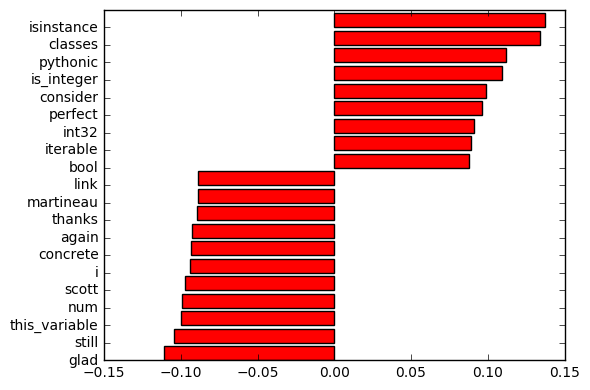

In [10]:
import matplotlib.pyplot as plt

sorted_x = sorted(imp_word_dict, key=imp_word_dict.get)
sorted_y = [imp_word_dict[x] for x in sorted_x]
#sorted_y.reverse()
#sorted_x.reverse()

plt.barh(range(len(sorted_x)), sorted_y, color='r')
plt.yticks(range(len(sorted_x)), sorted_x)

plt.tight_layout()
plt.show()

In [117]:
items

['@hulk: you seem to be under the impression that type is the right way to do this.',
 'it is (almost certainly) not.']

In [114]:
word_dict

{'canonical': 0.033773051465441559,
 'check': -0.071724063087750436,
 'duplicate': 0.039175234219797961,
 'possible': -0.024375775445865035,
 'python': 0.023019418089235359,
 's': 0.026437705602720015,
 'seem': 0.023015186501761417,
 'that': -0.0129267123790195,
 'this': -0.036796228488811485,
 'to': -0.01281247016068549,
 'way': 0.01404254601200421,
 'you': 0.056372161126580327}

## checking out what the data lime wants

In [55]:
#http://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']
newsgroups_test.data[83]

'From: johnchad@triton.unm.edu (jchadwic)\nSubject: Another request for Darwin Fish\nOrganization: University of New Mexico, Albuquerque\nLines: 11\nNNTP-Posting-Host: triton.unm.edu\n\nHello Gang,\n\nThere have been some notes recently asking where to obtain the DARWIN fish.\nThis is the same question I have and I have not seen an answer on the\nnet. If anyone has a contact please post on the net or email me.\n\nThanks,\n\njohn chadwick\njohnchad@triton.unm.edu\nor\n'

In [71]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

print(c.predict_proba([newsgroups_test.data[0]]))

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])


[[ 0.29  0.71]]


/home/dan-laptop/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 83
Probability(christian) = 0.446
True class: unhelpful
